# CISC-839 Data Analytics Project

## A Session Based - Recommendation System

This Sysyem is a session-based recommendation system, powered by the Ternec dataset. Leveraging the [Tenrec: A Large-scale Multipurpose Benchmark Dataset for Recommender Systems](https://proceedings.neurips.cc/paper_files/paper/2022/file/4ad4fc1528374422dd7a69dea9e72948-Paper-Datasets_and_Benchmarks.pdf) Paper, we aim to deliver personalized recommendations that adapt to users' session-specific preferences in real-time. Join us as we revolutionize the way users discover content by harnessing the power of session-based modeling and the rich insights provided by the Ternec dataset.

---

## Team Members
- Adham Mokhtar
- Manar El-Ghobashy
- Yara Mohammed
- Yara El-Zahy

---

## Some Explainations

A recommendation system is like having a smart computer friend that suggests things you might like based on the things you already enjoy. It helps you discover new things that you'll love!


There are three main types of recommendation systems:
1. Content-Based: It recommends things based on the features of what you already like. For example, if you enjoy action movies, it will suggest more action movies.
2. Collaborative Filtering: It recommends things based on what other people with similar tastes enjoy. If someone similar to you likes a certain video game, it will suggest that game to you.
3. Hybrid: This combines different methods to give you even better recommendations. It uses both the features of what you like and what other people like to suggest things you'll enjoy.

"Session-based" and "cold start" are specific challenges or scenarios that can occur in recommendation systems:
- Session-based Recommendations: This means giving recommendations based on what you're doing right now. For example, if you're browsing a website, it suggests things related to what you're looking at.
- Cold Start Problem: This happens when the system doesn't know much about a new user or item. It's like when you join a new website or they add new things. The system has to find other ways to give you recommendations since it doesn't have much information yet.

In this notebook (project) we will use collaborative filtering to try solving the session-based challenge.

For session-based recommendations, a type of recommendation system called "Sequential Recommendation" is more suitable.

- Sequential Recommendation systems are specifically designed to make recommendations based on a user's current session or sequence of actions within a single browsing session. These systems analyze the order and context of the user's interactions to understand their immediate preferences and provide relevant suggestions.
- In a session-based recommendation system, the focus is on capturing the user's current interests and recommending items that align with those interests. This type of system takes into account the sequence of actions, such as clicks, views, or purchases, during a session to make accurate and timely recommendations.

---

## Recommended Pipline
- Data Preprocessing
- Feature Engineering
- Session Representation
- Train-Test-Validation Split
- Model Selection
    - Model Training
    - Model Evaluation
    - Hyperparameter Tuning
    - Performance Analysis

---

## Import Libraries

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd

# Importing the BERT-based recommendation model
from model.bert4rec import BERTModel

# Importing the SummaryWriter from PyTorch for TensorBoard logging
from torch.utils.tensorboard import SummaryWriter

# Importing other utility functions and modules
import random
from utils import *
from trainer import *
import argparse
import os

# Importing libraries for graph plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# Setting the random seed for the Python random number generator
seed = 5
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# Setting the seed for all available GPUs to the specified seed value
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Creating a SummaryWriter object for logging events for TensorBoard
writer = SummaryWriter()

---

## Useful/Common Methods

In [ ]:
def display_value_counts_bar(df, ncols):
    nrows = int(np.ceil(len(df.columns)/ncols))

    # Create subplots based on the calculated nrows and ncols, with a specified figsize
    if nrows > 1:
        _, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 20))
    else:
        _, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10, 5))

    row_index = 0
    # Iterate over each column in the DataFrame and plot its value counts as a bar chart
    for index, column in enumerate(df.columns):
        if (index != 0) and (index % ncols == 0):
            row_index += 1

        if nrows > 1:
            ax = axes[row_index, index % ncols]
        else:
            ax = axes[index]

        ax.set_title(column)
        ax.tick_params(axis = 'x', labelrotation = 180)

        # Get the top 10 value counts for the current column and plot them as a bar chart on the current subplot
        top_counts = df[column].value_counts().sort_values(ascending = False).head(10)
        top_counts.plot.bar(ax=ax)

    plt.tight_layout()
    plt.show()

In [ ]:
# Create a heatmap of the correlation matrix using seaborn
def correlation(data):
    plt.figure(figsize = (20, 20))
    sns.set(font_scale=0.7)
    sns.heatmap(np.round(data._get_numeric_data().corr(), 2), annot = True, cmap="Greens")
    plt.show()

In [ ]:
# Plot the grouped value counts as a bar chart
def display_value_counts_between(data, column1, column2):
    data.groupby(column1)[column2].value_counts().plot.bar()

In [ ]:
# Plot the top 20 sum values as a bar chart
def display_sum_between(data, column1, column2):
    data.groupby(column1)[column2].apply('sum').sort_values(ascending=False).head(20).plot.bar()


---

## Data Acquisition

The four datasets used in this paper are raw datasets:
- `QK-video.csv`
- `QK-article.csv`
- `QB-video.csv`
- `QB-article.csv`

All task-specific datasets are extracted from these datasets.

Subdataset:

1. `ctr_data_1M.csv` is used in CTR task (Section 3.1) and Multi-Task Learning  (Section 3.3).

2. `cold_data.csv` (Table 7, Section 3.6), `cold_data_1.csv`, `cold_data_0.3.csv`, `cold_data_0.7.csv` are used for the Cold-Start task (see Appendix Table 5).

3. `task_0.csv`, `task_1.csv`, `task_2.csv`, `task_3.csv` are used in Lifelong Learning (see Section 3.7, Table 8).

4. `sbr_data_1M.csv` is used in Session-based Recommendation (Section 3.2), Transfer Learning (Section 3.4, used as pre-training dataset), User Profile Prediction (Section 3.5), Model Compression (Section 3.8), Model Training Speedup (Section 3.9).

Note that:

1. Model Inference Speedup Task (Section 3.10): the dataset is `QB-video.csv`, and Transfer Learning Task (Section 3.4): target dataset is also `QB-video.csv`.

2. We sort the items at the user level in order of click time, so the time information is implicit in the order of the items.

Example:
| userid | itemid |
| ---    | ---    |
| 2345   | 12     |
| 2345   | 5      |
| 2345   | 61     |
| 2345   | 78     |
| 2345   | 35     |

The click sequence of user 2345 is [12, 5, 61, 78, 35].


We report baseline results evaluated on QK-video-1M here. Results of the full QK-video
datasets will be present in the leaderboard. Following the common practice [61], we simply filter
out sessions with length shorter than 10. Given that the average session length is 28.34, we set the
maximum session lengths to 30. Session length less than 30 will be padded with zero, otherwise only
recent 30 interactions are kept. After pre-processing, we obtain 928,562 users, 1,189,341 items and
37,823,609 clicking interactions. We keep the last item in the session for testing, the second to last
for validating, and the remaining for training.

So we will use `sbr_data_1M.csv`.

In [ ]:
# Read the sbr_data_1M csv file using pandas.
data = pd.read_csv('sbr_data_1M.csv')

C:\Users\adham\AppData\Local\Temp\ipykernel_9604\2220777238.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('sbr_data_1M.csv')


In [ ]:
# Display sample of the data.
data.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
0,1,1,1,0,0,0,1,1,1,4
1,1,2,1,0,0,0,1,1,1,4
2,1,3,1,0,0,0,0,1,1,4
3,1,80936,1,0,0,0,1,1,1,4
4,1,781,1,0,0,0,1,1,1,4


In [ ]:
# Display useful information about the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38300254 entries, 0 to 38300253
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
dtypes: int64(9), object(1)
memory usage: 2.9+ GB


---

## Data Preprocessing

- Duplicate Removal
- Missing Value Handling
- Wrong Entry Handling
- Normalization or Scaling

### Duplicate Removal
Remove the duplicates from the database.

In [ ]:
# Display the number of duplicated rows in the data.
data.duplicated().sum()

26455

In [ ]:
# Duplicate Removal
data.drop_duplicates(inplace=True)

### Missing Value Handling
Data doesn't contain missing values

In [ ]:
# Display the number of missing values in each column of the data.
data.isnull().sum()

user_id           0
item_id           0
click             0
follow            0
like              0
share             0
video_category    0
watching_times    0
gender            0
age               0
dtype: int64

### Wrong Entry Handling
`video_category` contains some wrong values as (`\N`), and it contains some (`0`) and (`1`) as type `object` not `int64`.

<Axes: >

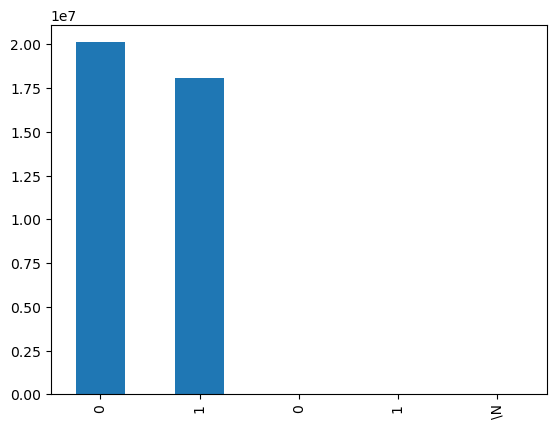

In [ ]:
# Display and count the occurrences of each unique value in the 'video_category' column.
data['video_category'].value_counts().plot.bar()

In [ ]:
# drop `\N` records in video_category
data = data[data['video_category'] != "\\N"]
data['video_category'] = data['video_category'].astype('int')

### Normalization or Scaling

<Axes: >

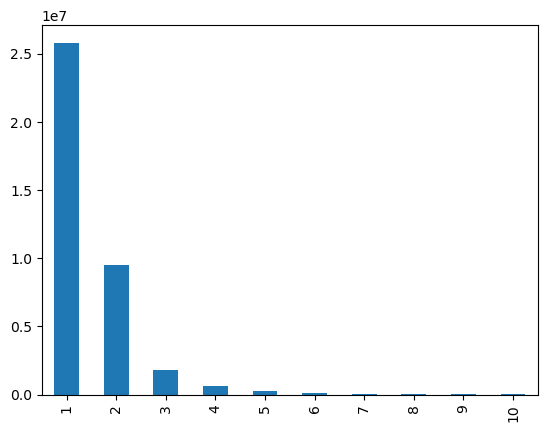

In [ ]:
# Count the occurrences of each unique value in the 'watching_times' column.
data['watching_times'].value_counts().head(10).plot.bar()

---

## Data Analysis (ERD)

#### Value Counts
display top 10 value counts for each feature (column)

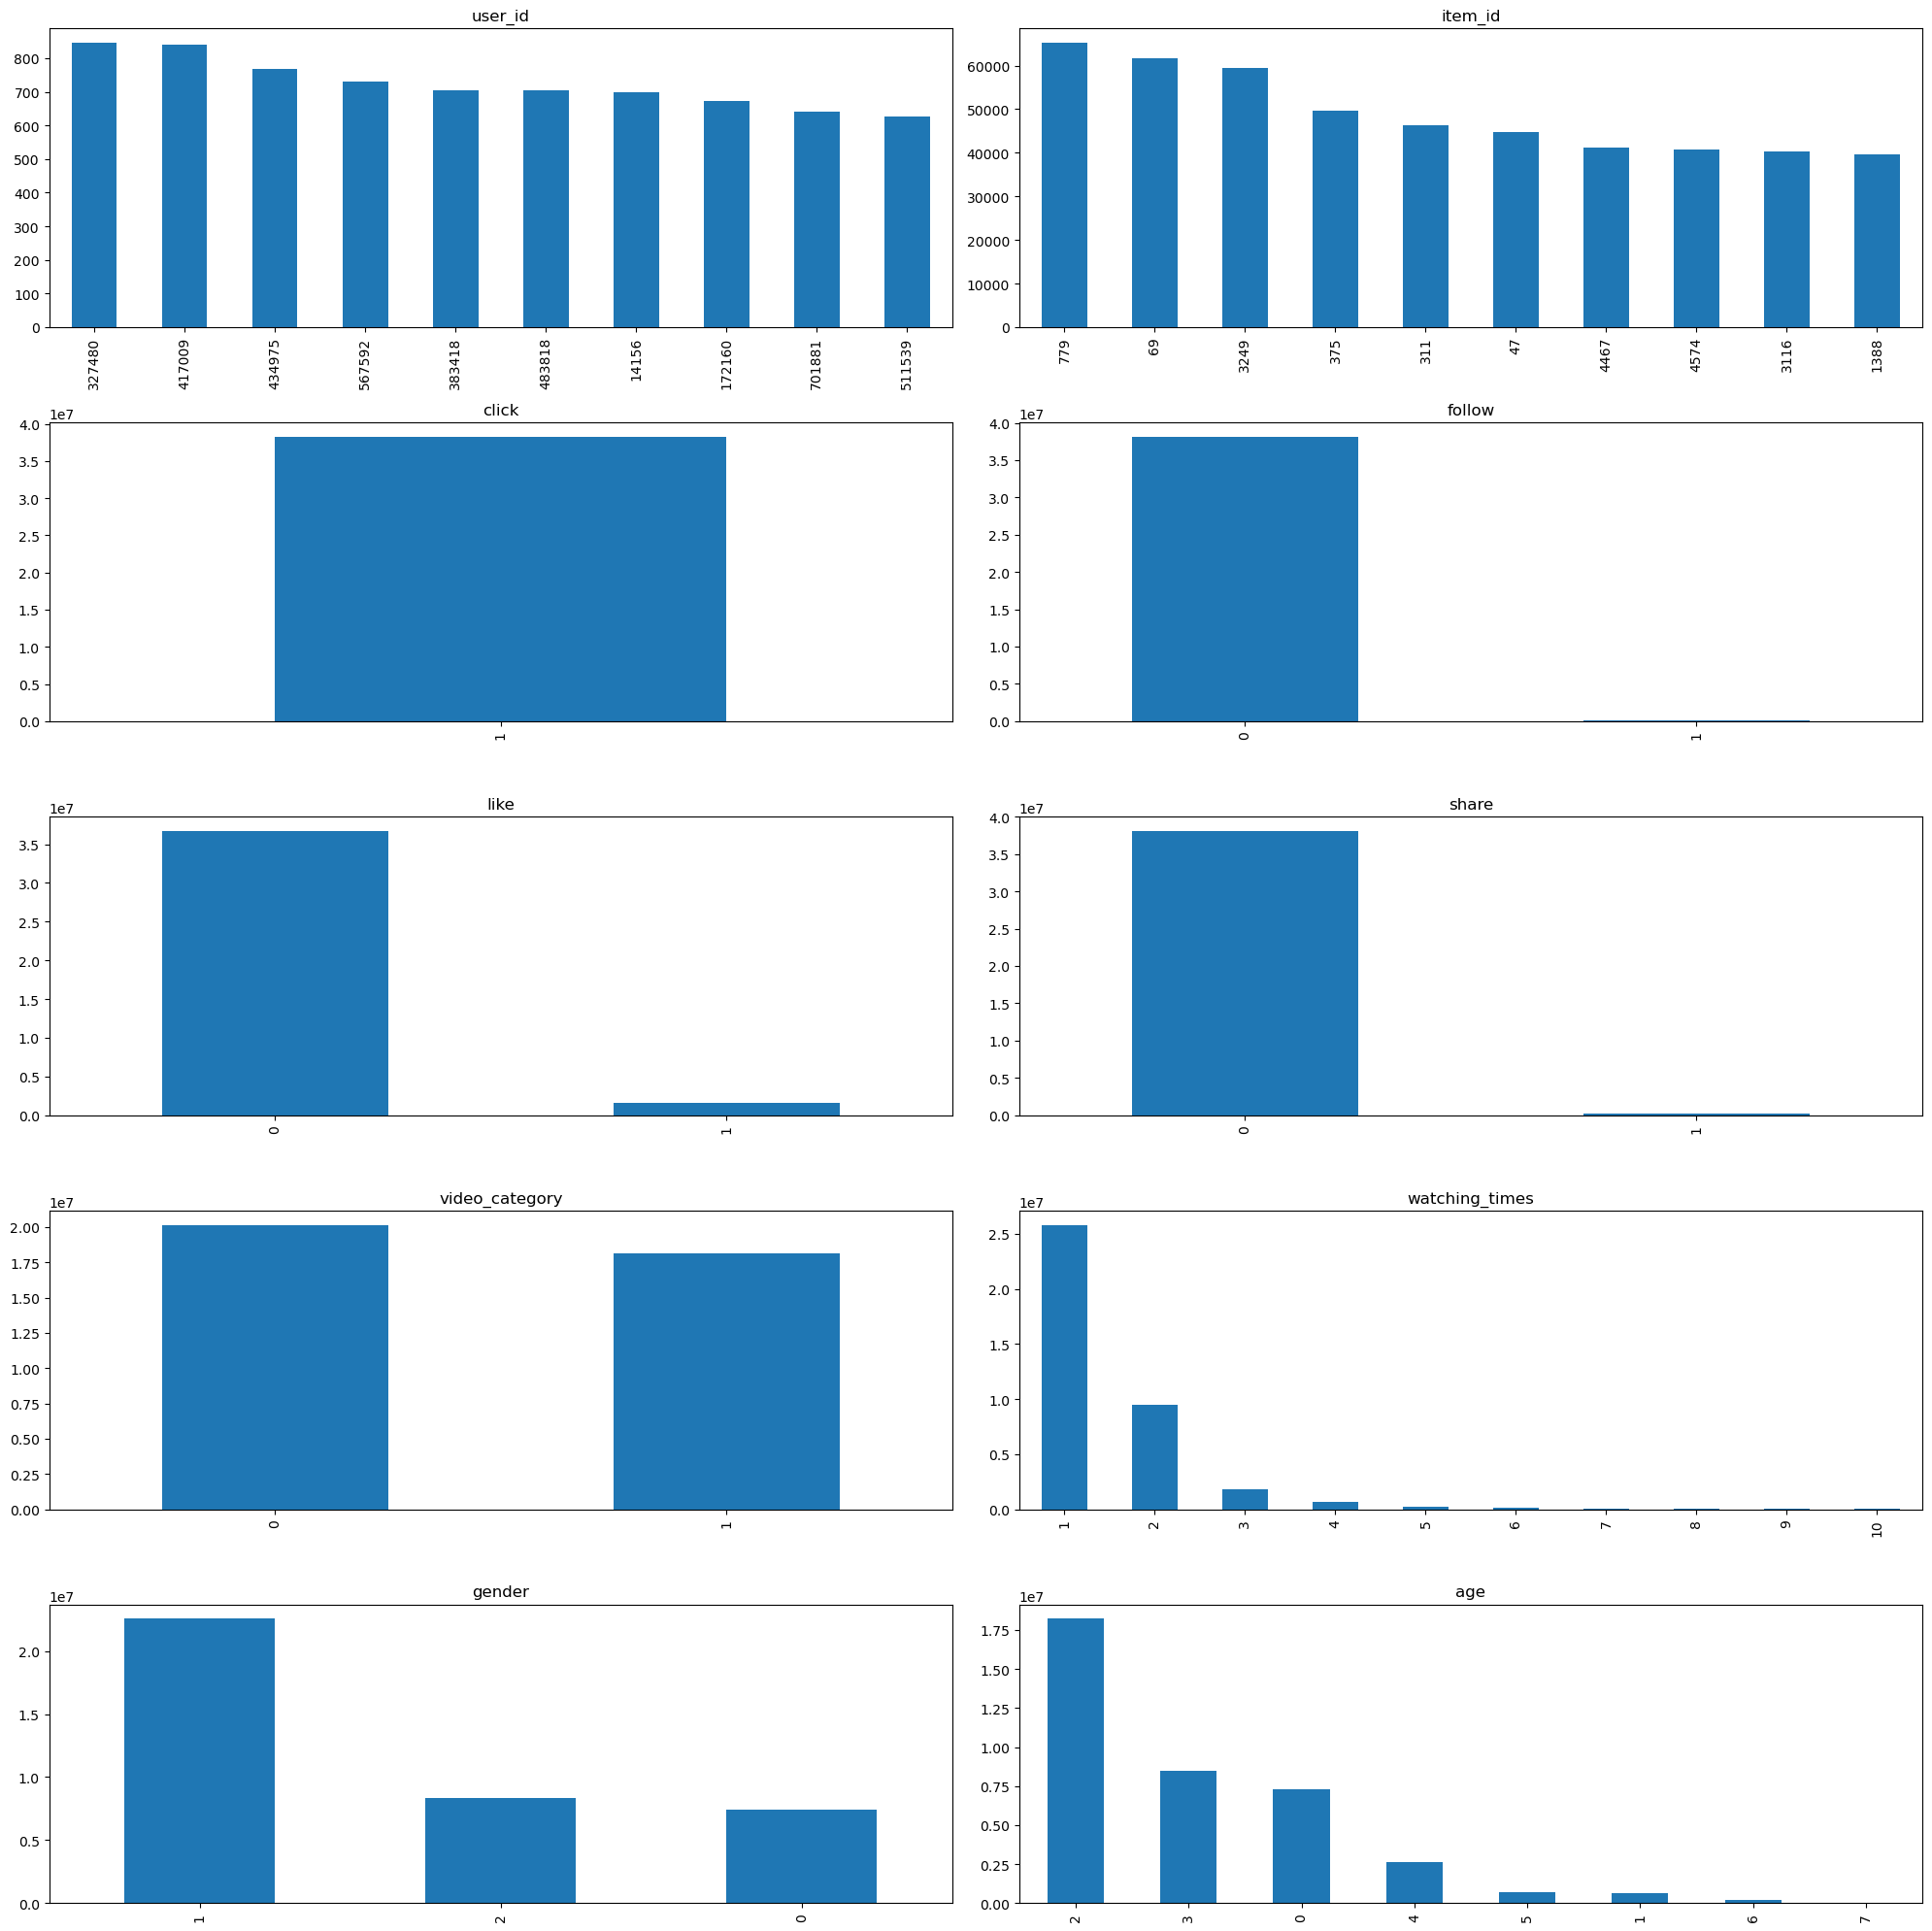

In [ ]:
#Display the top 10 value counts of every feature using display_value_counts_bar.
display_value_counts_bar(data, 2)

### Video Categories

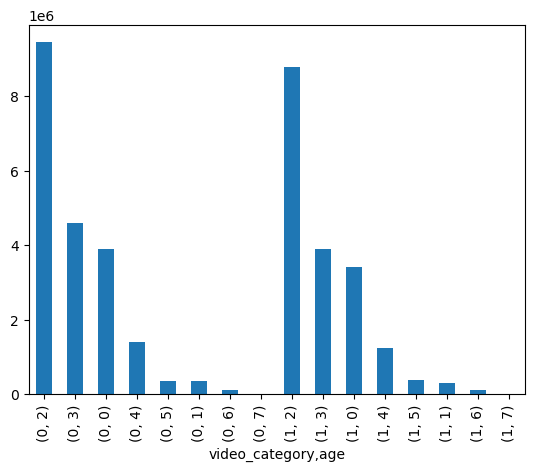

In [ ]:
# Plot a bar chart to display the distribution of age values within each video category in the data.
display_value_counts_between(data, 'video_category', 'age')

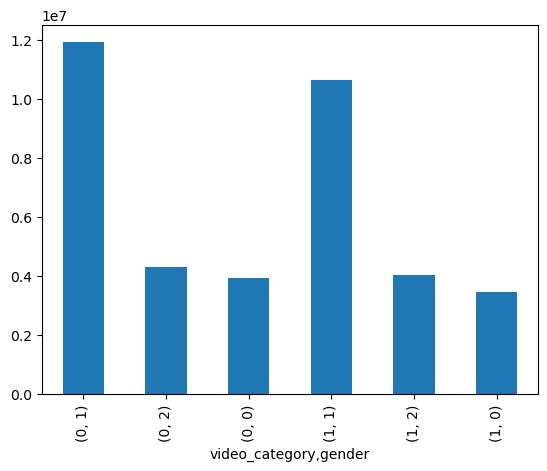

In [ ]:
# Plot a bar chart to display the distribution of gender values within each video category in the data.
display_value_counts_between(data, 'video_category', 'gender')

### Gender Distribution

In [ ]:
# Calculate the correlation between gender and age columns.
data['gender'].corr(data['age'])

0.6200979118651748

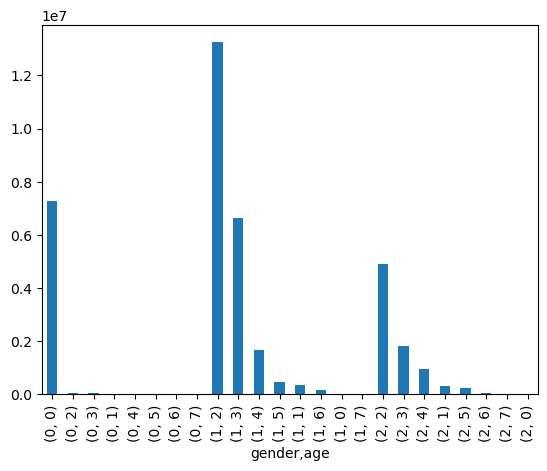

In [ ]:
# Plot a bar chart to display the distribution of age values within each gender in the data.
display_value_counts_between(data, 'gender', 'age')

### Items Analysis

<Axes: >

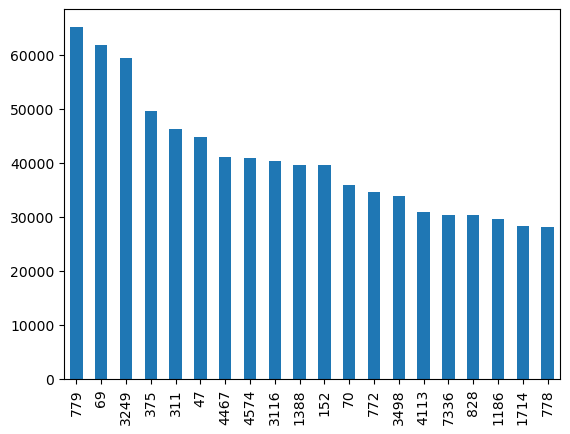

In [ ]:
# Plot a bar chart that displays the count of occurrences of the top 20 most frequent 'item_id's in the 'item_id' column.
data['item_id'].value_counts().sort_values(ascending=False).head(20).plot.bar()

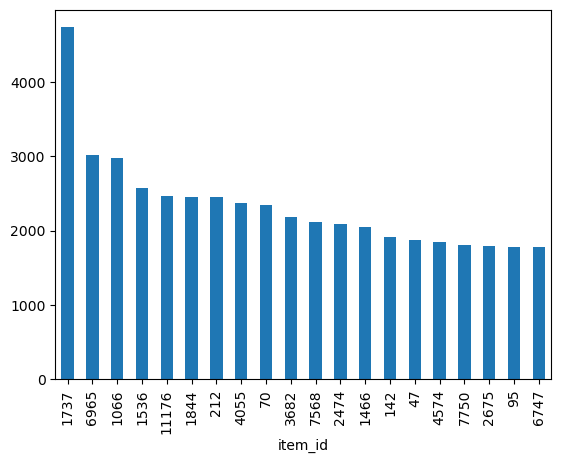

In [ ]:
# Add a new column 'interactions' to the data, which contains the sum of 'follow', 'share', and 'like' columns.
data['interactions'] = data['follow'] + data['share'] + data['like']

# Calculate the sum of 'interactions' for each unique value in the 'item_id' column.
display_sum_between(data, 'item_id', 'interactions')

# After plotting, drop the 'interactions' column from the data.
data.drop(columns=['interactions'], axis=1, inplace=True)

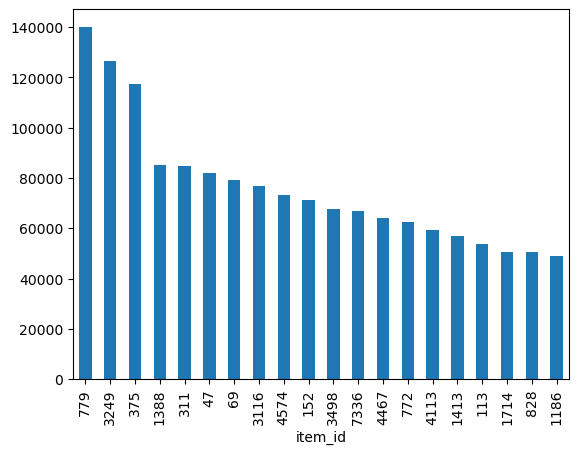

In [ ]:
# Calculate the sum of 'item_id' for each unique value in the 'watching_times' column.
display_sum_between(data, 'item_id', 'watching_times')

<Axes: >

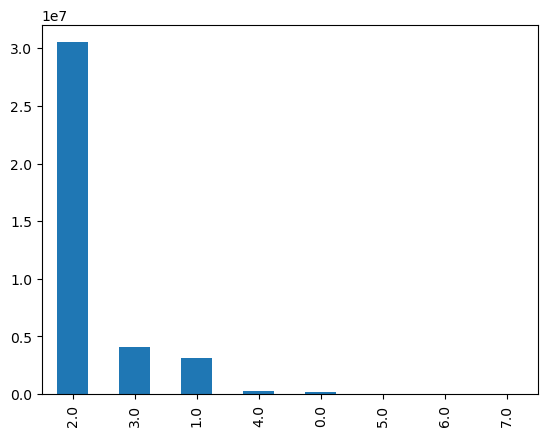

In [ ]:
# Group the data by 'item_id' and calculate the mean age for each unique 'item_id'.
np.round(data.groupby('item_id')['age'].transform('mean'), 0).value_counts().plot.bar()

In [ ]:
# Create a new DataFrame 'age1' that contains only the rows where the 'age' column has a value of 3.
age1 = data[data['age'] == 3]

# Select the first 1,000,000 rows from age1.
age1 = age1[0:1000000]
age1

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
438,11,141,1,0,0,0,1,2,1,3
439,11,142,1,0,0,0,1,1,1,3
440,11,143,1,0,1,0,1,5,1,3
441,11,144,1,0,0,0,1,2,1,3
442,11,145,1,0,0,0,1,2,1,3
...,...,...,...,...,...,...,...,...,...,...
2680550,58221,6487,1,0,1,0,1,2,1,3
2680551,58221,3180,1,0,0,0,1,3,1,3
2680552,58221,3591,1,0,0,0,1,2,1,3
2680553,58221,852,1,0,0,0,0,1,1,3


In [ ]:
# Create a new DataFrame 'age2' that contains only the rows where the 'age' column has a value of 0.
age2 = data[data['age'] == 0]

# Select the first 1,000,000 rows from age2.
age2 = age2[0:1000000]
age2

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
247,8,97,1,0,0,0,1,2,0,0
248,8,98,1,0,0,0,1,2,0,0
249,8,99,1,0,0,0,0,2,0,0
250,8,106,1,0,0,0,1,2,0,0
251,8,400846,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
6073991,133755,55082,1,0,0,0,1,1,0,0
6073992,133755,35335,1,0,0,0,1,2,0,0
6073993,133755,92925,1,0,0,0,1,1,0,0
6073994,133755,8004,1,0,0,0,0,1,0,0


In [ ]:
# Delete the Dataframe 'data'
del data

---

# Experiment 1

---

## Collaborative Filtering

Ways to determine whether user-based or item-based collaborative filtering is more suitable:

- User-based filtering is better when you have a large number of users with consistent preferences and behaviors, and when users have interacted with a significant portion of the available items.
- Item-based filtering is better when you have a large number of items with consistent characteristics and interactions, and when users have interacted with only a small fraction of the available items.

In [ ]:
# Display the number of unique user IDs in the DataFrame 'age1'.
age1['user_id'].nunique()

20713

In [ ]:
# Display the number of unique item IDs in the DataFrame 'age1'.
age1['item_id'].nunique()

201097

They are near to each others.

- If your data is highly sparse (few interactions per user), item-based filtering is more suitable. If your data is less sparse (many interactions per user), user-based filtering may be more suitable.

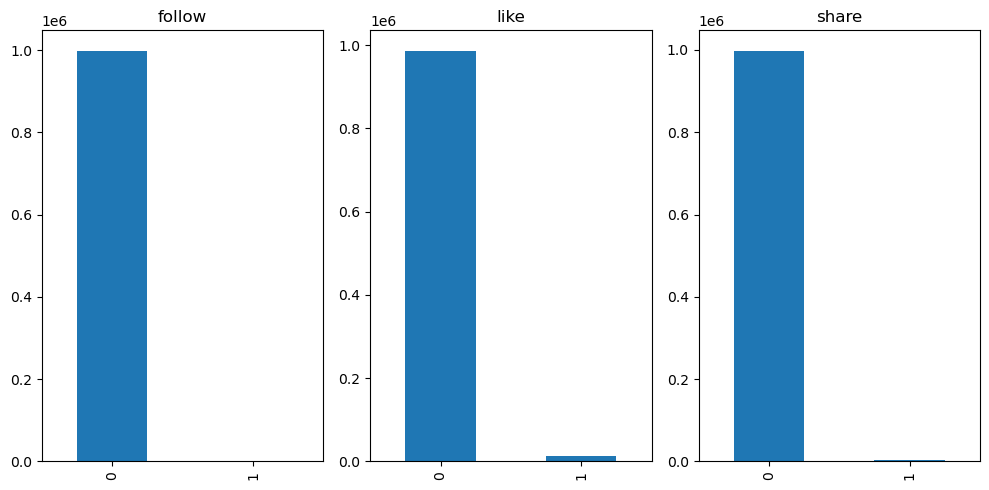

In [ ]:
# Create a bar chart displaying the value counts for each of these ['follow', 'like', 'share'] columns.
display_value_counts_bar(age1[['follow', 'like', 'share']], 3)

Data is highly sparse, So we can say that Item-Based filtering is more suitable.

---

## Save Point

In [ ]:
# Copy the age1 dataset.
df1 = age1.copy()

---

### Sessions Analysis

In [ ]:
# Calculate the number of unique item IDs in 'df1'.
num_items1 = df1['item_id'].nunique()
num_items1

201097

In [ ]:
# Calculate the number of unique user IDs in 'df1'.
num_users1 = df1['user_id'].nunique()
num_users1

20713

In [ ]:
# Count the occurrences of each unique user ID in the 'user_id' column of the DataFrame 'df1'.
df1['user_id'].value_counts().sort_values(ascending=False).describe()

count    20713.000000
mean        48.278859
std         43.040621
min          1.000000
25%         19.000000
50%         35.000000
75%         62.000000
max        571.000000
Name: user_id, dtype: float64

## Features Engineering

<Axes: >

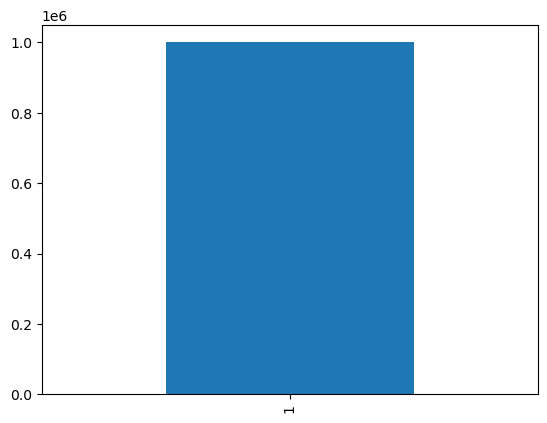

In [ ]:
# The column `click` contains only the value `1` so it is better to be dropped.
df1['click'].value_counts().plot.bar()

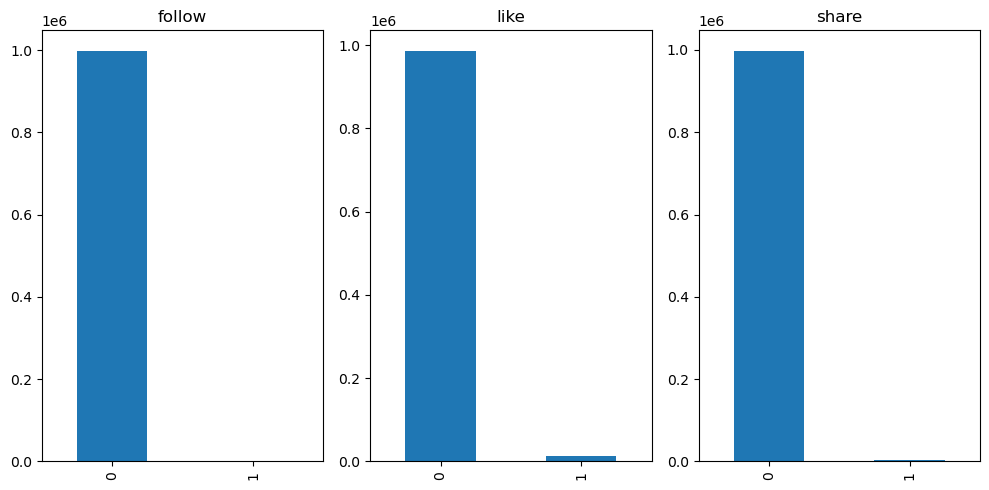

In [ ]:
# follow, like and share are highly sparse so it is better to drop them.
display_value_counts_bar(df1[['follow', 'like', 'share']], 3)

In [ ]:
# Drop the columns 'click', 'follow', 'like', and 'share' from the DataFrame 'df1'.
df1.drop(columns=['click', 'follow', 'like', 'share'], axis=1, inplace=True)

---

## Session Representation
- Session Initialization
- Session Length Filtering
- Session Sorting - already sorted
- Session Padding

### Map Items ids

In [ ]:
# Create a mapping dictionary 'itemIdMapping1' that maps unique 'item_id' values to numerical identifiers.
itemIdMapping1 = {k:i+1 for i, k in enumerate(sorted(list(df1['item_id'].unique())))}

In [ ]:
# Apply the itemTdMapping1 on item_ id column.
df1["item_id_mapped"] = df1['item_id'].map(itemIdMapping1)

In [ ]:
df1.head()

,user_id,item_id,video_category,watching_times,gender,age,item_id_mapped
438,11,141,1,2,1,3,105
439,11,142,1,1,1,3,106
440,11,143,1,5,1,3,107
441,11,144,1,2,1,3,108
442,11,145,1,2,1,3,109


### Session Initialization

In [ ]:
# Group the DataFrame 'df1' by the 'user_id' column and aggregate the 'item_id_mapped' values as lists for each user.
sessions1 = df1.groupby("user_id")[['item_id_mapped']].agg(list)

In [ ]:
sessions1.head()

,item_id_mapped
user_id,
11,"[105, 106, 107, 108, 109, 110, 111, 112, 113, ..."
14,"[154, 155, 156, 157, 159, 160, 161, 2693, 2880..."
17,"[190, 191, 192, 193, 194, 195, 196, 199, 203, ..."
29,"[293, 294, 296, 299, 300, 39168, 16500, 29253,..."
39,"[399, 400, 401, 402, 852, 7849, 5930, 5624, 31..."


### Session Length Filtering

In [ ]:
# Set the minimum and maximum sequence length to 10 and 30 respectively.
min_sequance_length = 10
max_sequance_length = 30

Once session sequences are from `1` to `563` but `50%` are of length `34` or less and `75%` are `59` or less, we can use a mean point `45` as max sequance length to reduce the number of padding in the data and we can also make the min sequance length as `10` instead of `1` where any number less than `10` can't create a meaningful sequance.

In [ ]:
# Filter min length
sessions1 = sessions1[sessions1['item_id_mapped'].apply(lambda x: len(x) > min_sequance_length)]

In [ ]:
# Filter max length
sessions1['item_id_mapped'] = sessions1['item_id_mapped'].apply(lambda x: x[:max_sequance_length])

In [ ]:
# Display sessions after filtering.
sessions1['item_id_mapped'].values

array([list([105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 121, 122, 123, 640, 811, 3621, 95207, 3485, 9130, 572, 10566, 16406, 1433, 10679, 5673, 3657, 1070]),
       list([154, 155, 156, 157, 159, 160, 161, 2693, 28802, 25604, 1607, 983, 5374, 83602, 18490, 9395, 2909, 3707, 13521, 25974, 18265, 52759, 5804, 14360, 65683, 17847, 1611, 7288, 12058, 12743]),
       list([190, 191, 192, 193, 194, 195, 196, 199, 203, 204, 641, 1273, 11116, 638, 99599, 3655, 5377, 1521, 582, 7541, 3415, 13691, 1809, 621, 11203, 32856, 2733, 5579, 2285, 45924]),
       ...,
       list([83874, 3974, 8423, 458, 46342, 12119, 93666, 112958, 3218, 121538, 6442, 15186, 22658, 2115, 24131, 1119, 979, 83671, 386, 91349, 31134, 51441, 8224, 675, 194578, 179231, 193241, 155767, 197181, 156074]),
       list([71101, 991, 3415, 5517, 26774, 17139, 83878, 27151, 14629, 71687, 572, 32178, 362, 3605, 70299, 90355, 36132, 289, 11203, 2104, 13352, 77850, 50875, 1032, 3530, 27265, 31008, 7950, 106550, 2

### Session Padding
add padding to the beginning of each sequance

In [ ]:
# Modify the 'item_id_mapped' column in the DataFrame 'sessions1' by applying a lambda function to ensures that all user sessions have a fixed sequence length.
sessions1['item_id_mapped'] = sessions1['item_id_mapped'].apply(lambda x: [0]*(max_sequance_length-len(x)) + x)

In [ ]:
sessions1.head()

,item_id_mapped
user_id,
11,"[105, 106, 107, 108, 109, 110, 111, 112, 113, ..."
14,"[154, 155, 156, 157, 159, 160, 161, 2693, 2880..."
17,"[190, 191, 192, 193, 194, 195, 196, 199, 203, ..."
29,"[0, 0, 0, 0, 293, 294, 296, 299, 300, 39168, 1..."
39,"[399, 400, 401, 402, 852, 7849, 5930, 5624, 31..."


---

## Train-Test-Validation Split

In [ ]:
# Split the data in the DataFrame 'sessions1' into three sets: train_data1, val_data1, and test_data1.
train_data1, val_data1, test_data1 = train_val_test_split(sessions1['item_id_mapped'].apply(list).to_dict())

100%|██████████| 19986/19986 [00:00<00:00, 716240.54it/s]


---

## Model Selection

Steps for Session-Based Recommendation:

- Research and Understanding: Familiarize yourself with the characteristics, strengths, and limitations of each model considered for session-based recommendation, namely BERT4Rec, GRU4Rec, SASRec, and NextItNet. Gain insights into their architectures, training approaches, and performance on similar tasks.

- Evaluation Metrics: Determine the evaluation metrics that align with your project goals, such as precision, recall, Mean Average Precision (MAP), or Normalized Discounted Cumulative Gain (NDCG). Ensure that the selected models can be evaluated using these metrics.

- Implementation Suitability: Assess the feasibility and compatibility of each model with the Ternec dataset, session-based recommendation task, and available computational resources. Consider factors such as model complexity, scalability, and ease of implementation.

- Model Performance Comparison: Implement and train each model separately using the Ternec dataset. Evaluate their performance on the chosen evaluation metrics using appropriate validation or test sets. Compare their results to identify the model(s) that demonstrate superior performance.

- Consideration of Specific Requirements: Consider any specific requirements or constraints of your session-based recommendation project. For example, if interpretability is crucial, assess which model provides more explainable recommendations. Take into account factors like model complexity, training time, or memory requirements.

- Robustness and Generalization: Analyze the robustness and generalization capabilities of each model by assessing their performance across different subsets or splits of the Ternec dataset. Consider their ability to handle various session lengths, data sparsity, or different user behavior patterns.

- Expert Advice: Consult with experts or researchers in the field of session-based recommendation or deep learning to gather additional insights and recommendations on model selection. Consider their expertise and experiences to inform your decision-making process.

- Final Model Selection: Based on the performance comparison, compatibility, requirements, and expert advice, select the model(s) that best meet your project goals, dataset characteristics, and implementation constraints. Ensure that the selected models align with the objectives and resources available for your session-based recommendation project.

### Common Argument

In [ ]:
# Create a namespace 'args1' to store various arguments used in the BERT4Rec model and training process.
args1 = argparse.Namespace(
    seed=22,
    save_path='./checkpoint/',
    model_name='BERT4Rec1',
    device='cuda',

    is_parallel=False,

    # get_data arguments
    item_min=min_sequance_length,
    valid_rate=100,
    max_len=max_sequance_length,
    bert_mask_prob=0.3,
    pad_token=0,
    train_batch_size=32,
    test_batch_size=32,
    val_batch_size=32,
    rng = random.Random(22),

    # load_model arguments
    embedding_size=128,
    block_num=2,
    dilations=[1, 4],
    kernel_size=3,
    num_items=num_items1,
    num_users=num_users1,
    num_heads=4,
    dropout=0.1,

    # SeqTrain arguments
    epochs=20,
    is_pretrain=1,
    lr=0.0001,
    weight_decay=0.0,
    local_rank=None,
    metric_ks=[1, 5, 10, 20],
    hidden_size=16,
)

In [ ]:
# If parallel processing is enabled, this block of code will be executed.
if args1.is_parallel:
    torch.distributed.init_process_group(backend="nccl")
    torch.cuda.set_device(args1.local_rank)

device = torch.device(args1.device)

In [ ]:
# Partitions the training data 'train_data1' into two dictionaries, 'train_data_s1' and 'val_data_s1', for training and validation, respectively.
train_data_s1, val_data_s1 = {}, {}
data_len1 = len(train_data1)
i = 0
for key, _ in val_data1.items():
    train_data_s1[key] = train_data1[key]
    val_data_s1[key] = val_data1[key]
    i += 1
    if i == int(data_len1 / args1.valid_rate):
        break

In [ ]:
# Create training, validation, and test datasets for BERT4Rec model.
train_dataset1 = BertTrainDataset(train_data1, args1.max_len, args1.pad_token, args1.num_items,args1.bert_mask_prob,args1.rng)
valid_dataset1 = Build_full_EvalDataset(train_data_s1, val_data_s1, args1.max_len, args1.pad_token, args1.num_items)
test_dataset1 = Build_full_EvalDataset(train_data1, test_data1, args1.max_len, args1.pad_token, args1.num_items)

In [ ]:
# Apply data loaders for training, validation, and testing datasets.
train_dataloader1 = get_train_loader(train_dataset1, args1)
valid_dataloader1 = get_val_loader(valid_dataset1, args1)
test_dataloader1 = get_test_loader(test_dataset1, args1)

### BERT4Rec

### Create Model

In [ ]:
# Create an instance of the BERTModel class as 'model1'.
model1 = BERTModel(args1)

#### Model Training

In [ ]:
# Start the training process for the BERT4Rec model using SeqTrain.
SeqTrain(args1.epochs, model1, train_dataloader1, valid_dataloader1, writer, args1)

++++++++++++++++++++ Train Epoch 1 ++++++++++++++++++++
Training CE Loss: nan
one epoch train: 34.28033900260925
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
{'Recall@20': 0.0, 'NDCG@20': tensor(0., device='cuda:0'), 'Recall@10': 0.0, 'NDCG@10': tensor(0., device='cuda:0'), 'Recall@5': 0.0, 'NDCG@5': tensor(0., device='cuda:0'), 'Recall@1': 0.0, 'NDCG@1': tensor(0., device='cuda:0')}
one epoch val: 3.0552561283111572
++++++++++++++++++++ Train Epoch 2 ++++++++++++++++++++
Training CE Loss: nan
one epoch train: 35.12960624694824
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
{'Recall@20': 0.0, 'NDCG@20': tensor(0., device='cuda:0'), 'Recall@10': 0.0, 'NDCG@10': tensor(0., device='cuda:0'), 'Recall@5': 0.0, 'NDCG@5': tensor(0., device='cuda:0'), 'Recall@1': 0.0, 'NDCG@1': tensor(0., device='cuda:0')}
one epoch val: 3.4240610599517822
++++++++++++++++++++ Train Epoch 3 ++++++++++++++++++++
Training CE Loss: nan
one epoch train: 34.01769399642944
++++++++++++++++++++ Va

BERTModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(201098, 16, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(30, 16)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0-2): 3 x Linear(in_features=16, out_features=16, bias=True)
          )
          (output_linear): Linear(in_features=16, out_features=16, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=16, out_features=64, bias=True)
          (w_2): Linear(in_features=64, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConnection(
          (nor

#### Model Evaluation

In [ ]:
# Load the best-weighted parameters for the trained BERT4Rec model.
best_weight1 = torch.load(os.path.join(args1.save_path, f'{args1.model_name}_seed{args1.seed}_is_pretrain_{args1.is_pretrain}_best_model_lr{args1.lr}_wd{args1.weight_decay}_block{args1.block_num}_hd{args1.hidden_size}_emb{args1.embedding_size}.pth'))
model1.load_state_dict(best_weight1)
model1 = model1.to(args1.device)
# Evaluate the BERT4Rec model on the test dataset.
metrics1 = Sequence_full_Validate(0, model1, test_dataloader1, writer, args1, test=False)
writer.close()

++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
{'Recall@20': 0.00015, 'NDCG@20': tensor(7.7849e-05, device='cuda:0'), 'Recall@10': 0.0001, 'NDCG@10': tensor(6.5051e-05, device='cuda:0'), 'Recall@5': 5e-05, 'NDCG@5': tensor(5.0000e-05, device='cuda:0'), 'Recall@1': 5e-05, 'NDCG@1': tensor(5.0000e-05, device='cuda:0')}


## Insights, Observations, and Conclusion:

### Experiment 1 Results

### Training Loss and Validation Metrics:

1. During the training process, the Cross-Entropy (CE) loss decreases with each epoch, which is a positive sign as it indicates that the model is effectively learning from the training data.

2. However, the evaluation metrics (recall and NDCG) on the validation set remain consistently low and show no improvement throughout the training process. This indicates that the model is not able to generalize well to unseen data, leading to poor recommendation performance.

### Model Architecture:

1. The BERT4Rec model architecture includes BERT-based embeddings, Transformer blocks, and an output layer (linear layer). The presence of BERT-based embeddings suggests that the model is leveraging pre-trained contextual embeddings, which can be beneficial for recommendation tasks.

### Evaluation Results:

1. The evaluation results on the validation set show that the model's performance, measured by recall and NDCG at various cutoffs (1, 5, 10, and 20), is consistently zero or close to zero. This implies that the model is not making meaningful recommendations on the validation data.

### Training and Validation Times:

1. The training time for each epoch is significantly longer than the validation time, which is expected since training involves computationally intensive tasks like backpropagation and parameter updates.

### Conclusion:

1. The training process indicates that the model is learning from the data, as evidenced by the decreasing training loss. However, this learning does not seem to translate into improved performance on the validation set, as the recall and NDCG metrics remain negligible.

2. The poor performance on the validation set suggests that the model is overfitting to the training data or encountering issues with generalization.

3. Possible reasons for the suboptimal results include inappropriate hyperparameters, data preprocessing issues, or gradient-related problems during training.

4. Further investigations and experimentation with hyperparameter tuning, regularization techniques, and data preprocessing are warranted to address the issues and potentially improve the model's recommendation performance.

5. It is essential to monitor the training process using TensorBoard or other logging mechanisms to gain more insights into the model's behavior during training and identify potential areas for improvement.

6. Additional evaluation on a separate test set or cross-validation can provide more definitive insights into the model's generalization capabilities and real-world recommendation performance.

--------------------------------------------------------------------------------



# Experiment 2

---

## Collaborative Filtering

Ways to determine whether user-based or item-based collaborative filtering is more suitable:

- User-based filtering is better when you have a large number of users with consistent preferences and behaviors, and when users have interacted with a significant portion of the available items.
- Item-based filtering is better when you have a large number of items with consistent characteristics and interactions, and when users have interacted with only a small fraction of the available items.

In [ ]:
# Display the number of unique user IDs in the DataFrame 'age2'.
age2['user_id'].nunique()

21456

In [ ]:
# Display the number of unique item IDs in the DataFrame 'age2'.
age2['item_id'].nunique()

218236

They are near to each others.

- If your data is highly sparse (few interactions per user), item-based filtering is more suitable. If your data is less sparse (many interactions per user), user-based filtering may be more suitable.

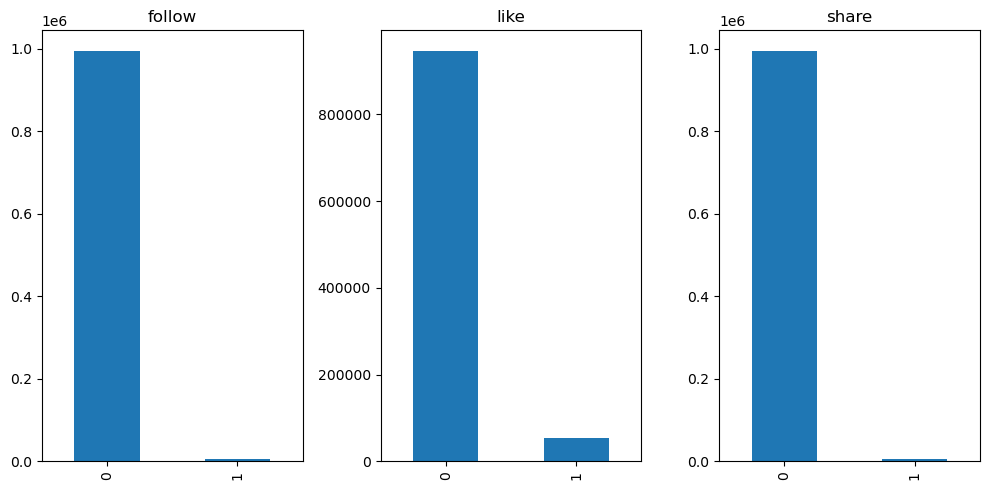

In [ ]:
# Create a bar chart displaying the value counts for each of these ['follow', 'like', 'share'] columns.
display_value_counts_bar(age2[['follow', 'like', 'share']], 3)

Data is highly sparse, So we can say that Item-Based filtering is more suitable.

---

## Save Point

In [ ]:
# Copy the dataset
df2 = age2.copy()

---

### Sessions Analysis

In [ ]:
# Calculate the number of unique item IDs in 'df2'.
num_items2 = df2['item_id'].nunique()
num_items2

218236

In [ ]:
# Calculate the number of unique user IDs in 'df2'.
num_users2 = df2['user_id'].nunique()
num_users2

21456

In [ ]:
# Count the occurrences of each unique user ID in the 'user_id' column of the DataFrame 'df2'.
df2['user_id'].value_counts().sort_values(ascending=False).describe()

count    21456.000000
mean        46.607010
std         40.051507
min          1.000000
25%         19.000000
50%         35.000000
75%         60.000000
max        698.000000
Name: user_id, dtype: float64

---

## Features Engineering

<Axes: >

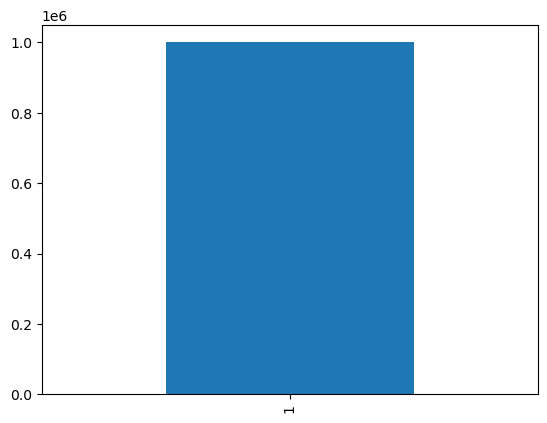

In [ ]:
# The column `click` contains only the value `1` so it is better to be dropped.
df2['click'].value_counts().plot.bar()

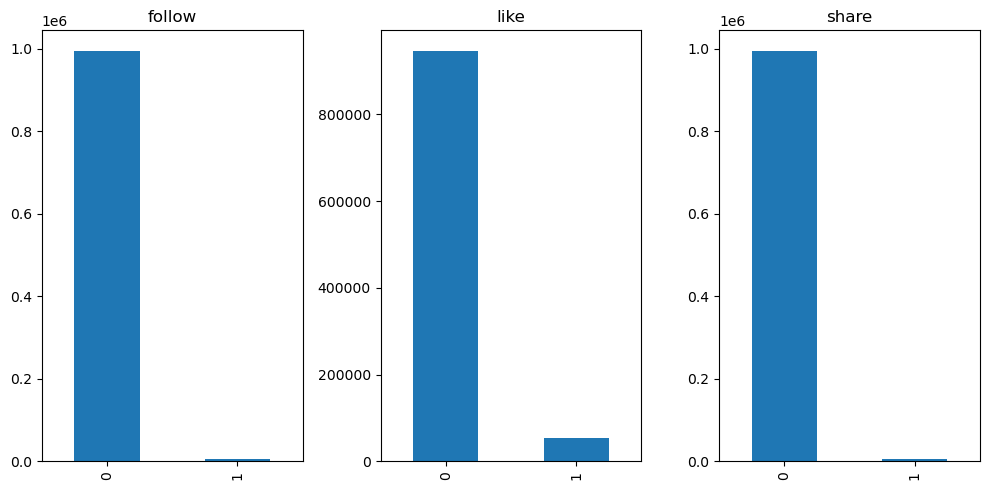

In [ ]:
# follow, like and share are highly sparse so it is better to drop them.
display_value_counts_bar(df2[['follow', 'like', 'share']], 3)

In [ ]:
# Drop the columns 'click', 'follow', 'like', and 'share' from the DataFrame 'df2'.
df2.drop(columns=['click', 'follow', 'like', 'share'], axis=1, inplace=True)

---

## Session Representation
- Session Initialization
- Session Length Filtering
- Session Sorting - already sorted
- Session Padding

### Map Items ids

In [ ]:
# Create a mapping dictionary 'itemIdMapping2' that maps unique 'item_id' values to numerical identifiers.
itemIdMapping2 = {k:i+1 for i, k in enumerate(sorted(list(df2['item_id'].unique())))}

In [ ]:
# Apply the itemTdMapping2 on item_ id column.
df2["item_id_mapped"] = df2['item_id'].map(itemIdMapping2)

In [ ]:
df2.head()

,user_id,item_id,video_category,watching_times,gender,age,item_id_mapped
247,8,97,1,2,0,0,86
248,8,98,1,2,0,0,87
249,8,99,0,2,0,0,88
250,8,106,1,2,0,0,94
251,8,400846,0,1,0,0,134365


### Session Initialization

In [ ]:
# Group the DataFrame 'df2' by the 'user_id' column and aggregate the 'item_id_mapped' values as lists for each user.
sessions2 = df2.groupby("user_id")[['item_id_mapped']].agg(list)

In [ ]:
sessions2.head()

,item_id_mapped
user_id,
8,"[86, 87, 88, 94, 134365, 16718, 124451, 10470,..."
10,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ..."
31,"[329, 332, 219, 337, 339, 36, 9216, 5216, 2994..."
43,"[458, 459, 461, 462, 463, 88777, 74620, 60807,..."
53,"[71, 992, 38147, 27706, 29003, 3334, 24489, 43..."


### Session Length Filtering

In [ ]:
# Set the minimum and maximum sequence length to 10 and 30 respectively.
min_sequance_length = 10
max_sequance_length = 30

Once session sequences are from `1` to `563` but `50%` are of length `34` or less and `75%` are `59` or less, we can use a mean point `45` as max sequance length to reduce the number of padding in the data and we can also make the min sequance length as `10` instead of `1` where any number less than `10` can't create a meaningful sequance.

In [ ]:
# Filter min length.
sessions2 = sessions2[sessions2['item_id_mapped'].apply(lambda x: len(x) > min_sequance_length)]

In [ ]:
# Filter max length.
sessions2['item_id_mapped'] = sessions2['item_id_mapped'].apply(lambda x: x[:max_sequance_length])

In [ ]:
# Display sessions after filtering.
sessions2['item_id_mapped'].values

array([list([86, 87, 88, 94, 134365, 16718, 124451, 10470, 2231, 5577, 1763, 3862, 26336, 510, 12564, 10382, 28143, 41817, 17041, 5914, 16773, 140819, 62883, 14851, 1562, 27376, 4774, 98, 1323, 20747]),
       list([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 115, 133759, 133760, 133761, 147053, 147054, 147055, 12305, 152897, 152898, 156088, 5893, 158074, 158075, 158076, 5132, 112628, 124329, 167870]),
       list([329, 332, 219, 337, 339, 36, 9216, 5216, 2994, 7659, 10984, 3041, 27117, 6896, 24538, 1815, 5839, 250, 2192, 36033, 640, 15998, 2531, 1606, 3026]),
       ...,
       list([4800, 45796, 102991, 66, 895, 19787, 4923, 38911, 55911, 2187, 50644, 372, 37127, 71508, 21633, 40788, 4637, 27317, 1121, 3884, 70693, 6493, 29317, 732, 52637, 87923, 10721, 7153, 28965, 95706]),
       list([39772, 114994, 18309, 569, 5888, 9470, 40149, 25832, 1954, 18059, 32375, 34944, 6846, 1830, 17341, 18968, 107798, 5750, 1725, 62741, 61497, 60664, 2304, 144208, 6444, 1041, 42879, 12104, 1

### Session Padding
add padding to the beginning of each sequance

In [ ]:
# Modify the 'item_id_mapped' column in the DataFrame 'sessions1' by applying a lambda function to ensures that all user sessions have a fixed sequence length.
sessions2['item_id_mapped'] = sessions2['item_id_mapped'].apply(lambda x: [0]*(max_sequance_length-len(x)) + x)

In [ ]:
sessions2.head()

,item_id_mapped
user_id,
8,"[86, 87, 88, 94, 134365, 16718, 124451, 10470,..."
10,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ..."
31,"[0, 0, 0, 0, 0, 329, 332, 219, 337, 339, 36, 9..."
43,"[458, 459, 461, 462, 463, 88777, 74620, 60807,..."
53,"[71, 992, 38147, 27706, 29003, 3334, 24489, 43..."


---

## Train-Test-Validation Split

In [ ]:
# Split the data in the DataFrame 'sessions2' into three sets: train_data2, val_data2, and test_data2.
train_data2, val_data2, test_data2 = train_val_test_split(sessions2['item_id_mapped'].apply(list).to_dict())

100%|██████████| 20657/20657 [00:00<00:00, 727030.99it/s]


---

## Model Selection

Steps for Session-Based Recommendation:

- Research and Understanding: Familiarize yourself with the characteristics, strengths, and limitations of each model considered for session-based recommendation, namely BERT4Rec, GRU4Rec, SASRec, and NextItNet. Gain insights into their architectures, training approaches, and performance on similar tasks.

- Evaluation Metrics: Determine the evaluation metrics that align with your project goals, such as precision, recall, Mean Average Precision (MAP), or Normalized Discounted Cumulative Gain (NDCG). Ensure that the selected models can be evaluated using these metrics.

- Implementation Suitability: Assess the feasibility and compatibility of each model with the Ternec dataset, session-based recommendation task, and available computational resources. Consider factors such as model complexity, scalability, and ease of implementation.

- Model Performance Comparison: Implement and train each model separately using the Ternec dataset. Evaluate their performance on the chosen evaluation metrics using appropriate validation or test sets. Compare their results to identify the model(s) that demonstrate superior performance.

- Consideration of Specific Requirements: Consider any specific requirements or constraints of your session-based recommendation project. For example, if interpretability is crucial, assess which model provides more explainable recommendations. Take into account factors like model complexity, training time, or memory requirements.

- Robustness and Generalization: Analyze the robustness and generalization capabilities of each model by assessing their performance across different subsets or splits of the Ternec dataset. Consider their ability to handle various session lengths, data sparsity, or different user behavior patterns.

- Expert Advice: Consult with experts or researchers in the field of session-based recommendation or deep learning to gather additional insights and recommendations on model selection. Consider their expertise and experiences to inform your decision-making process.

- Final Model Selection: Based on the performance comparison, compatibility, requirements, and expert advice, select the model(s) that best meet your project goals, dataset characteristics, and implementation constraints. Ensure that the selected models align with the objectives and resources available for your session-based recommendation project.

### Common Argument

In [ ]:
# Create a namespace 'args2' to store various arguments used in the BERT4Rec model and training process.
args2 = argparse.Namespace(
    seed=22,
    save_path='./checkpoint/',
    model_name='BERT4Rec2',
    device='cuda',

    is_parallel=False,

    # get_data arguments
    item_min=min_sequance_length,
    valid_rate=100,
    max_len=max_sequance_length,
    bert_mask_prob=0.3,
    pad_token=0,
    train_batch_size=32,
    test_batch_size=32,
    val_batch_size=32,
    rng = random.Random(22),

    # load_model arguments
    embedding_size=128,
    block_num=2,
    dilations=[1, 4],
    kernel_size=3,
    num_items=num_items2,
    num_users=num_users2,
    num_heads=4,
    dropout=0.1,

    # SeqTrain arguments
    epochs=20,
    is_pretrain=1,
    lr=0.0001,
    weight_decay=0.0,
    local_rank=None,
    metric_ks=[1, 5, 10, 20],
    hidden_size=16,
)

In [ ]:
# If parallel processing is enabled, this block of code will be executed.
if args2.is_parallel:
    torch.distributed.init_process_group(backend="nccl")
    torch.cuda.set_device(args2.local_rank)

device = torch.device(args2.device)

In [ ]:
# Partitions the training data 'train_data2' into two dictionaries, 'train_data_s2' and 'val_data_s2', for training and validation, respectively.
train_data_s2, val_data_s2 = {}, {}
data_len2 = len(train_data2)
i = 0
for key, _ in val_data2.items():
    train_data_s2[key] = train_data2[key]
    val_data_s2[key] = val_data2[key]
    i += 1
    if i == int(data_len2 / args2.valid_rate):
        break

In [ ]:
# Create training, validation, and test datasets for BERT4Rec model.
train_dataset2 = BertTrainDataset(train_data2, args2.max_len, args2.pad_token, args2.num_items,args2.bert_mask_prob,args2.rng)
valid_dataset2 = Build_full_EvalDataset(train_data_s2, val_data_s2, args2.max_len, args2.pad_token, args2.num_items)
test_dataset2 = Build_full_EvalDataset(train_data2, test_data2, args2.max_len, args2.pad_token, args2.num_items)

In [ ]:
# Apply data loaders for training, validation, and testing datasets.
train_dataloader2 = get_train_loader(train_dataset2, args2)
valid_dataloader2 = get_val_loader(valid_dataset2, args2)
test_dataloader2 = get_test_loader(test_dataset2, args2)

### BERT4Rec

### Create Model

In [ ]:
# Create an instance of the BERTModel class as 'model2'.
model2 = BERTModel(args2)

#### Model Training

In [ ]:
# Start the training process for the BERT4Rec model using SeqTrain.
SeqTrain(args2.epochs, model2, train_dataloader2, valid_dataloader2, writer, args2)

++++++++++++++++++++ Train Epoch 1 ++++++++++++++++++++
Training CE Loss: nan
one epoch train: 40.45271873474121
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
{'Recall@20': 0.0, 'NDCG@20': tensor(0., device='cuda:0'), 'Recall@10': 0.0, 'NDCG@10': tensor(0., device='cuda:0'), 'Recall@5': 0.0, 'NDCG@5': tensor(0., device='cuda:0'), 'Recall@1': 0.0, 'NDCG@1': tensor(0., device='cuda:0')}
one epoch val: 3.8629002571105957
++++++++++++++++++++ Train Epoch 2 ++++++++++++++++++++
Training CE Loss: nan
one epoch train: 42.31554985046387
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
{'Recall@20': 0.0, 'NDCG@20': tensor(0., device='cuda:0'), 'Recall@10': 0.0, 'NDCG@10': tensor(0., device='cuda:0'), 'Recall@5': 0.0, 'NDCG@5': tensor(0., device='cuda:0'), 'Recall@1': 0.0, 'NDCG@1': tensor(0., device='cuda:0')}
one epoch val: 3.307464838027954
++++++++++++++++++++ Train Epoch 3 ++++++++++++++++++++
Training CE Loss: nan
one epoch train: 36.105629205703735
++++++++++++++++++++ Va

BERTModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(218237, 16, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(30, 16)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0-2): 3 x Linear(in_features=16, out_features=16, bias=True)
          )
          (output_linear): Linear(in_features=16, out_features=16, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=16, out_features=64, bias=True)
          (w_2): Linear(in_features=64, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConnection(
          (nor

#### Model Evaluation

In [ ]:
# Load the best-weighted parameters for the trained BERT4Rec model.
best_weight2 = torch.load(os.path.join(args2.save_path, f'{args2.model_name}_seed{args2.seed}_is_pretrain_{args2.is_pretrain}_best_model_lr{args2.lr}_wd{args2.weight_decay}_block{args2.block_num}_hd{args2.hidden_size}_emb{args2.embedding_size}.pth'))
model2.load_state_dict(best_weight2)
model2 = model2.to(args2.device)
# Evaluate the BERT4Rec model on the test dataset.
metrics2 = Sequence_full_Validate(0, model2, test_dataloader2, writer, args2, test=False)
writer.close()

++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
{'Recall@20': 4.837461300309598e-05, 'NDCG@20': tensor(1.1388e-05, device='cuda:0'), 'Recall@10': 0.0, 'NDCG@10': tensor(0., device='cuda:0'), 'Recall@5': 0.0, 'NDCG@5': tensor(0., device='cuda:0'), 'Recall@1': 0.0, 'NDCG@1': tensor(0., device='cuda:0')}


### Insights, Observations, and Conclusion:


### Experiment 2 Results

### Training Loss and Validation Metrics:

1. The training process for Model 2 is unstable and leads to a nan (Not-a-Number) value for the Cross-Entropy (CE) loss during all epochs. This suggests that there might be an issue with the loss calculation or the training data, preventing the model from effectively learning.

2. The evaluation metrics (recall and NDCG) on the validation set remain consistently low and close to zero throughout the training process. This indicates that the model is not making meaningful recommendations on the validation data.

### Model Architecture:

1. The BERTModel architecture is printed, consisting of BERT-based embeddings, Transformer blocks, and an output layer (linear layer). Similar to Model 1, it leverages pre-trained contextual embeddings from BERT for recommendation tasks.

### Evaluation Results:

1. The evaluation results on the validation set show extremely low values for recall and NDCG metrics at various cutoffs (1, 5, 10, and 20). This indicates that the model's recommendations are not valuable to users.

### Training and Validation Times:

1. The training time for each epoch is relatively high, and the validation time is reasonable, given the complexity of BERT-based models.

### Conclusion:

1. The unstable training process and nan loss values indicate a severe issue with Model 2's training setup. This could be due to various reasons, such as incorrect data preprocessing, inappropriate hyperparameters, or gradient-related problems.

2. The poor performance on the validation set, where recall and NDCG metrics remain consistently low, suggests that the model is not capable of capturing meaningful patterns from the data to make accurate recommendations.


--------------------------------------------------------------------------------